<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/bootcamp/tutorials/quickstart/image_search_with_milvus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>   <a href="https://github.com/milvus-io/bootcamp/blob/master/bootcamp/tutorials/quickstart/image_search_with_milvus.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View%20on%20GitHub-555555?style=flat&logo=github&logoColor=white" alt="GitHub Repository"/>

# Image Search with Milvus

<img src="https://raw.githubusercontent.com/milvus-io/bootcamp/master/bootcamp/tutorials/quickstart/apps/image_search_with_milvus/pics/image_search_demo.png"/>

In this notebook, we will show you how to use Milvus to search for similar images in a dataset. We will use a subset of the [ImageNet](https://www.image-net.org/) dataset, then search for an image of an Afghan hound to demonstrate this.


## Dataset Preparation
First, we need to load the dataset and unextract it for further processing.

In [ ]:
!wget https://github.com/milvus-io/pymilvus-assets/releases/download/imagedata/reverse_image_search.zip
!unzip -q -o reverse_image_search.zip

## Prequisites

To run this notebook, you need to have the following dependencies installed:
- pymilvus>=2.4.2
- timm
- torch
- numpy
- sklearn
- pillow 

To run Colab, we provide the handy commands to install the necessary dependencies.

In [ ]:
!pip install pymilvus --upgrade
!pip install timm

> If you are using Google Colab, to enable dependencies just installed, you may need to **restart the runtime** (click on the "Runtime" menu at the top of the screen, and select "Restart session" from the dropdown menu).

## Define the Feature Extractor
Then, we need to define a feature extractor which extracts embedding from an image using timm's ResNet-34 model.

In [ ]:
import torch
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


class FeatureExtractor:
    def __init__(self, modelname):
        # Load the pre-trained model
        self.model = timm.create_model(
            modelname, pretrained=True, num_classes=0, global_pool="avg"
        )
        self.model.eval()

        # Get the input size required by the model
        self.input_size = self.model.default_cfg["input_size"]

        config = resolve_data_config({}, model=modelname)
        # Get the preprocessing function provided by TIMM for the model
        self.preprocess = create_transform(**config)

    def __call__(self, imagepath):
        # Preprocess the input image
        input_image = Image.open(imagepath).convert("RGB")  # Convert to RGB if needed
        input_image = self.preprocess(input_image)

        # Convert the image to a PyTorch tensor and add a batch dimension
        input_tensor = input_image.unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            output = self.model(input_tensor)

        # Extract the feature vector
        feature_vector = output.squeeze().numpy()

        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()

## Create a Milvus Collection
Then we need to create Milvus collection to store the image embeddings

In [2]:
from pymilvus import MilvusClient

# Set up a Milvus client
client = MilvusClient(uri="example.db")
# Create a collection in quick setup mode
if client.has_collection(collection_name="image_embeddings"):
    client.drop_collection(collection_name="image_embeddings")
client.create_collection(
    collection_name="image_embeddings",
    vector_field_name="vector",
    dimension=512,
    auto_id=True,
    enable_dynamic_field=True,
    metric_type="COSINE",
)

> As for the argument of `MilvusClient`:
> - Setting the `uri` as a local file, e.g.`./milvus.db`, is the most convenient method, as it automatically utilizes [Milvus Lite](https://milvus.io/docs/milvus_lite.md) to store all data in this file.
> - If you have large scale of data, you can set up a more performant Milvus server on [docker or kubernetes](https://milvus.io/docs/quickstart.md). In this setup, please use the server uri, e.g.`http://localhost:19530`, as your `uri`.
> - If you want to use [Zilliz Cloud](https://zilliz.com/cloud), the fully managed cloud service for Milvus, adjust the `uri` and `token`, which correspond to the [Public Endpoint and Api key](https://docs.zilliz.com/docs/on-zilliz-cloud-console#free-cluster-details) in Zilliz Cloud.

## Insert the Embeddings to Milvus
We will extract embeddings of each image using the ResNet34 model and insert images from the training set into Milvus.

In [3]:
import os

extractor = FeatureExtractor("resnet34")

root = "./train"
insert = True
if insert is True:
    for dirpath, foldername, filenames in os.walk(root):
        for filename in filenames:
            if filename.endswith(".JPEG"):
                filepath = dirpath + "/" + filename
                image_embedding = extractor(filepath)
                client.insert(
                    "image_embeddings",
                    {"vector": image_embedding, "filename": filepath},
                )

'query'

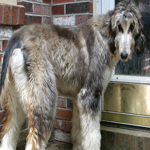

'results'

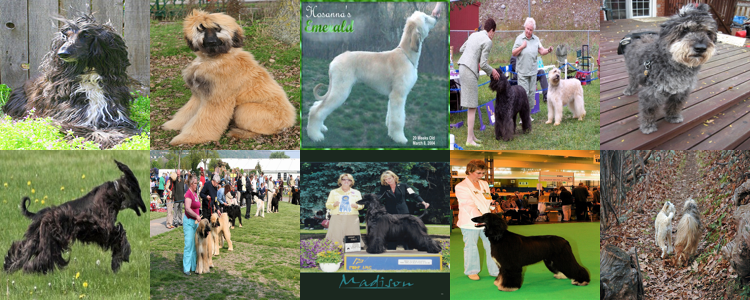

In [5]:
from IPython.display import display

query_image = "./test/Afghan_hound/n02088094_4261.JPEG"

results = client.search(
    "image_embeddings",
    data=[extractor(query_image)],
    output_fields=["filename"],
    search_params={"metric_type": "COSINE"},
)
images = []
for result in results:
    for hit in result[:10]:
        filename = hit["entity"]["filename"]
        img = Image.open(filename)
        img = img.resize((150, 150))
        images.append(img)

width = 150 * 5
height = 150 * 2
concatenated_image = Image.new("RGB", (width, height))

for idx, img in enumerate(images):
    x = idx % 5
    y = idx // 5
    concatenated_image.paste(img, (x * 150, y * 150))
display("query")
display(Image.open(query_image).resize((150, 150)))
display("results")
display(concatenated_image)

We can see that most of the images are from the same category as the search image, which is the Afghan hound. This means that we found similar images to the search image.

## Quick Deploy

To learn about how to start an online demo with this tutorial, please refer to [the example application](https://github.com/milvus-io/bootcamp/tree/master/bootcamp/tutorials/quickstart/apps/image_search_with_milvus).